# Network creation & Analysis

### <span style="color:teal">Creating nodes and edges for the network</span>

From the csv files created in the previous notebook(check 02.ipynb), we will be creating a node list and edge list <br>to use as input for creating a netowork representation using netowrkX.

In [235]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors

### <span style="color:teal">Helper Functions</span>

In [370]:
def remove_nan_empty_rows(dataframe):
    dataframe.replace('', np.nan, inplace=True)
    dataframe.dropna(inplace=True)
    dataframe.dropna(how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='any', inplace=True)
    dataframe.replace(np.nan, '', inplace=True)
    
    return dataframe

#removing self-loops from the edge list dataframe
def remove_selfloop(df, column1, column2):
    # Drop rows where the values in column1 and column2 are equal
    df = df[df[column1] != df[column2]]

    # Reset the index of the dataframe
    df = df.reset_index(drop=True)

    return df

#adding nodes from node_list
def add_nodes_from_dataframe(df):
    # Create an empty graph
    G = nx.DiGraph()

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Extract the node name from the row
        node_name = row['video ID']   #this could be the vide ID in our case

        # Extract the attributes from the row (excluding the 'Node' column)
        attributes = row.drop('video ID').to_dict()   

        # Add the node with its attributes to the graph
        G.add_node(node_name, **attributes)

    return G

#adding edges from edge_list
def edges_from_df(df,graph):
    
    g_nodes = set(graph.nodes())

    set2 = set(list(graph.nodes))
    for idx,row in tqdm(df.iterrows()):
        source = row[0]
        target = row[1]
        #print(source,target) this works just fine
        set1 = {source,target}
        is_proper_subset = set1.issubset(set2) and set1 != set2
        if is_proper_subset:
            graph.add_edges_from([(source,target)])
        else:
            continue
    return graph

# writing a function for graph creation
def create_Digraph(df_nlist,df_elist):
    #step 1 - declare the graph variable
    G = nx.DiGraph()
    
    #step 2 - add nodes from the nlist
    G = add_nodes_from_dataframe(df_nlist)
    
    #step 3 - check for orpahn nodes
    G = edges_from_df(df_elist,G)
    
    #step 4 - remove all orpahn nodes
    orphan_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
    print(len(orphan_nodes),' orphan nodes removed')
    
    return G

# function for making a dataframe of attributes of a list of nodes
def get_node_attributes(graph, nodes):
    # nodes should be a list of node IDs
    # Create an empty DataFrame to store node attributes
    node_attributes = pd.DataFrame(columns=graph.nodes[nodes[0]])

    # Iterate over the nodes and collect their attributes
    for node in nodes:
        attributes = graph.nodes[node]
        node_attributes = node_attributes.append(attributes, ignore_index=True)

    return node_attributes

# function to export .gexf file for gephi
def export(graph_var,name):
    if '.gexf.gz' in name: 
        nx.write_gexf(graph_var,name)
    else:
        print('enter a name with file type as `.gexf.gz`')

### <span style="color:teal">Data Import and Preparation</span>

Now we importe the network data from the CSVs we created earlier.

In [4]:
# Importing the edge lists

eList1 = pd.read_csv("eList1.csv",delimiter=',',low_memory=False)
eList2 = pd.read_csv("eList2.csv",delimiter=',',low_memory=False)

In [5]:
len(eList1)  # length after import -> 15,41,415

1541415

In [6]:
# now we process the edge list dataframes so that they are ready to used for the graph creator function

# removing nan/ NaN and other such values
eList1 = remove_nan_empty_rows(eList1)
# removing self-loops 
eList1 = remove_selfloop(eList1, '0', '1')
# removing duplicates
eList1.drop_duplicates(inplace=True)

In [7]:
len(eList1) # length after cleaning -> 14,70,158

1470158

In [8]:
# lets do the same cleaning for the second edge list from 2008
len(eList2) # length after import -> 21,90,420

2190420

In [9]:
# removing nan/ NaN and other such values
eList2 = remove_nan_empty_rows(eList2)
# removing self-loops 
eList2 = remove_selfloop(eList2, '0', '1')
# removing duplicates
eList2.drop_duplicates(inplace=True)

In [10]:
len(eList2) # length after cleaning -> 15,33,099

1533099

Certain decisions were made after much trail and error with the data, the following steps are a result of those trails.

For example, we will be choosing only half the the edges from the edge lists to keep the network graph managable for computation at later stages. The choice of selecting which nodes to keep and which to drop is completly aribitrary as the dataframe is not sorted in any sense except maybe time they were crawled through by the web scrapper.

Similar approach is taken for the node list.

In [11]:
# Select half of the dataframe for 2007 edge list
sub7 = eList1.head(int(len(eList1)/2))
sub8 = eList2.head(int(len(eList2)/2))

In [12]:
# Importing the node lists with the attribute data
NL7 = pd.read_csv("S_data07.csv",delimiter=',',low_memory=False)
NL8 = pd.read_csv("S_data08.csv",delimiter=',',low_memory=False)

In [13]:
len(NL7) # length after import -> 3,84,474

384474

In [14]:
# cleaning the node list
NL7 = remove_nan_empty_rows(NL7)
# selecting half the node list
NL7_1 = NL7.head(int(len(NL7)/2))
NL7_2 = NL7.tail(int(len(NL7)/2))
len(NL7_1) # 1,90,206
len(NL7_2) # 1,90,206

190206

In [15]:
len(NL8) # length after import -> 4,97,246

497246

In [16]:
# cleaning the node list
NL8 = remove_nan_empty_rows(NL8)
# selecting half the node list
NL8_1 = NL8.head(int(len(NL8)/2))
NL8_2 = NL8.tail(int(len(NL8)/2))
len(NL8_1) # 2,48,350
len(NL8_2) # 2,48,350

248350

## Making the graph 

Making the graph for the april 2007 now, we will be storing it in the variable called `g1`

In [17]:
g1 = nx.DiGraph()
g1 = add_nodes_from_dataframe(NL7_1)
g1 = edges_from_df(eList1,g1)

1470158it [00:35, 41167.80it/s]


In [18]:
# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,90,206
print("Number of edges:", g1.number_of_edges())  # 1,90,877

Number of nodes: 190206
Number of edges: 190877


In [20]:
# now we remove the orphan nodes from this graph
# 1 - Find orphan nodes
orphan_nodes = [node for node in g1.nodes() if g1.in_degree(node) == 0 and g1.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g1.remove_nodes_from(orphan_nodes)

0


In [21]:
# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,08,243
print("Number of edges:", g1.number_of_edges())  # 1,90,877

Number of nodes: 108243
Number of edges: 190877


<hr>
Making the graph for the april 2008 now, we will be storing it in the variable called `g2`

In [22]:
g2 = nx.DiGraph()
g2 = add_nodes_from_dataframe(NL8_1)
g2 = edges_from_df(eList2,g2)

1533099it [00:37, 40676.15it/s]


In [23]:
# check the node and edge count
print("Number of nodes:", g2.number_of_nodes())  # 2,48,350
print("Number of edges:", g2.number_of_edges())  # 2,66,613

Number of nodes: 248350
Number of edges: 266613


In [24]:
# now we remove the orphan nodes from this graph
# 1 - Find orphan nodes
orphan_nodes = [node for node in g2.nodes() if g2.in_degree(node) == 0 and g2.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g2.remove_nodes_from(orphan_nodes)

102861


In [25]:
# check the node and edge count
print("Number of nodes:", g2.number_of_nodes())  # 1,45,489
print("Number of edges:", g2.number_of_edges())  # 2,66,613

Number of nodes: 145489
Number of edges: 266613


### <span style="color:teal">Doing some basic analysis of the network's structure</span>

We will be conducting some basic measurements to understand the nature of the network before going for specific analysis. First we take the network graph for the year 2007 - that is `g1`.

In [26]:
'''
def average_shortest_path(G):
    if not nx.is_weakly_connected(G):
        # Calculate the average shortest path length of each weakly connected component
        avg_shortest_paths = []
        for component in tqdm(nx.weakly_connected_components(G)):
            subgraph = G.subgraph(component)
            avg_shortest_path = nx.average_shortest_path_length(subgraph)
            avg_shortest_paths.append(avg_shortest_path)
    
        # Calculate the average shortest path length across all weakly connected components
        avg_shortest_path = sum(avg_shortest_paths) / len(avg_shortest_paths)
    
        print("Average Shortest Path Length (across weakly connected components):", avg_shortest_path)
    else:
        # Calculate the average shortest path length of the graph
        avg_shortest_path = nx.average_shortest_path_length(G)
        print("Average Shortest Path Length:", avg_shortest_path)
        
    return avg_shortest_path

def small_wrldCalc(G):
    # Calculate the clustering coefficient of the directed graph
    cc = nx.average_clustering(G)
    print(cc)

    # Calculate the average shortest path length of the directed graph
    asp = average_shortest_path(G)

    # Generate a random graph with the same number of nodes and edges as the directed graph
    Gg = nx.to_undirected(G)
    random_graph = nx.random_reference(Gg)

    # Calculate the clustering coefficient of the random graph
    cc_random = nx.average_clustering(random_graph)

    # Calculate the average shortest path length of the random graph
    asp_random = average_shortest_path(random_graph)

    # Calculate the small world index
    small_world_index = (cc / cc_random) / (asp / asp_random)

    print("Small World Index:", small_world_index)
'''

In [27]:
#small_wrldCalc(g1)

In [28]:
def diameter_directed(G):
    # Get strongly connected components
    components = nx.strongly_connected_components(G)

    # Calculate the maximum diameter among components
    max_diameter = 0
    for component in components:
        component_graph = G.subgraph(component)
        diameter = nx.diameter(component_graph)
        if diameter > max_diameter:
            max_diameter = diameter

    print("Network Diameter:", max_diameter)

In [29]:
print("Density:", nx.density(g1))
diameter_directed(g1)
print("Reciprocity:", nx.reciprocity(g1))
print("Average in-degree:", sum(dict(g1.in_degree()).values()) / g1.number_of_nodes())
print("Average out-degree:", sum(dict(g1.out_degree()).values()) / g1.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(g1))
print("Transitivity:", nx.transitivity(g1))
print("Number of strongly connected components:", nx.number_strongly_connected_components(g1))  #output - 2,79,984
print("Number of weakly connected components:", nx.number_weakly_connected_components(g1)) # output - 23,818
print(nx.is_directed_acyclic_graph(g1))

Density: 1.629138368411498e-05
Network Diameter: 20
Reciprocity: 0.2669886890510643
Average in-degree: 1.7634119527359737
Average out-degree: 1.7634119527359737
Assortativity coefficient: 0.30243865280017784
Transitivity: 0.47550274445530777
Number of strongly connected components: 89797
Number of weakly connected components: 13786
False


In [30]:
print(nx.attribute_assortativity_coefficient(g1, "category"))  #output -> 0.5997368829782115
print(nx.attribute_assortativity_coefficient(g1, "rate"))      #output -> 0.09425041007829454
print(nx.attribute_assortativity_coefficient(g1, "ratings"))   #output -> 0.07666366912630876
print(nx.attribute_assortativity_coefficient(g1, "comments"))  #output -> 0.0905428121827432
#print(nx.attribute_assortativity_coefficient(g1, "views"))     #output -> 0.0015915504082061908

0.5997368829782111
0.09425041007829454
0.07666366912630876
0.0905428121827432


In [ ]:
print(nx.attribute_assortativity_coefficient(g2, "category"))  #output -> 0.5276899000024023
print(nx.attribute_assortativity_coefficient(g2, "rate"))      #output -> 0.05164874282976598
print(nx.attribute_assortativity_coefficient(g2, "ratings"))   #output -> 0.02717917361672679
print(nx.attribute_assortativity_coefficient(g2, "comments"))  #output -> 0.031683894216178794
print(nx.attribute_assortativity_coefficient(g2, "views"))     #output -> 0.0

0.5276899000024023
0.05164874282976598
0.02717917361672679
0.031683894216178794


In [ ]:
# Compute assortativity coefficient based on attributes 'attr1' and 'attr2'
assortativity_coefficient = nx.attribute_assortativity_coefficient(g1, 'category', 'rate')
#print("Assortativity coefficient:", assortativity_coefficient)

In [31]:
# Find the giant component
giant_component = max(nx.weakly_connected_components(g1), key=len)

# Create the subgraph from the giant component
giant_subgraph = g1.subgraph(giant_component)

# Print the number of nodes and edges in the subgraph
print("Number of nodes in the subgraph:", giant_subgraph.number_of_nodes())
print("Number of edges in the subgraph:", giant_subgraph.number_of_edges())

Number of nodes in the subgraph: 40389
Number of edges in the subgraph: 85520


In [ ]:
print("average shortest path length - ",nx.average_shortest_path_length(giant_subgraph)) # output -> 0.0024737974990778314

In [33]:
def common_week(G):
    # Get weakly connected components
    weak_components = list(nx.weakly_connected_components(G))

    # Store the subgraphs
    subgraphs = []
    for component in weak_components:
        subgraph = G.subgraph(component)
        subgraphs.append(subgraph)

    # Compare subgraphs for common nodes
    common_nodes = []
    for i in tqdm(range(len(subgraphs))):
        for j in range(i + 1, len(subgraphs)):
            common = set(subgraphs[i].nodes()).intersection(subgraphs[j].nodes())
            if len(common) >= 2:
                common_nodes.append((i, j, common))

    # Print the common nodes
    if len(common_nodes) > 0:
        for i, j, common in common_nodes:
            print(f"Common nodes between subgraph {i} and subgraph {j}: {common}")
    else:
        print("No pair of subgraphs have at least two common nodes.")

In [ ]:
#common_week(g1)

In [34]:
def common_week_edge(G):

    # Get weakly connected components
    weak_components = list(nx.weakly_connected_components(G))

    # Check for edges between components
    edge_exists = False
    for i in tqdm(range(len(weak_components))):
        for j in range(i + 1, len(weak_components)):
            nodes_i = weak_components[i]
            nodes_j = weak_components[j]

            # Check if any edge exists between nodes in components i and j
            for node_i in nodes_i:
                for node_j in nodes_j:
                    if G.has_edge(node_i, node_j):
                        edge_exists = True
                        break

                if edge_exists:
                    break

            if edge_exists:
                break

        if edge_exists:
            break

    # Print the result
    if edge_exists:
        print("There is an edge between a node in component i and a node in component j.")
    else:
        print("No edge exists between a node in any two components.")

In [ ]:
#common_week_edge(g1)

In [ ]:
#lets try to compute the same for the giant-subgraph and see the results
print(nx.attribute_assortativity_coefficient(giant_subgraph, "category"))  #output -> 0.5776139091133229
print(nx.attribute_assortativity_coefficient(giant_subgraph, "rate"))      #output -> 0.07817503451978605
print(nx.attribute_assortativity_coefficient(giant_subgraph, "ratings"))   #output -> 0.06156763924787793
print(nx.attribute_assortativity_coefficient(giant_subgraph, "comments"))  #output -> 0.07185061025675915
print(nx.attribute_assortativity_coefficient(giant_subgraph, "views"))     #output -> 0.0021108581141249735

In [36]:
print("Density:", nx.density(giant_subgraph))
diameter_directed(giant_subgraph)
print("Reciprocity:", nx.reciprocity(giant_subgraph)) # output - 0.23101028999064546
print("Average in-degree:", sum(dict(giant_subgraph.in_degree()).values()) / giant_subgraph.number_of_nodes())
print("Average out-degree:", sum(dict(giant_subgraph.out_degree()).values()) / giant_subgraph.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(giant_subgraph))
print("Transitivity:", nx.transitivity(giant_subgraph))
print("Number of strongly connected components:", nx.number_strongly_connected_components(giant_subgraph))  #output - 32360
print("Number of weakly connected components:", nx.number_weakly_connected_components(giant_subgraph)) # output - 1
print(nx.is_directed_acyclic_graph(giant_subgraph)) # output - false

Density: 5.2426666465395345e-05
Network Diameter: 20
Reciprocity: 0.23101028999064546
Average in-degree: 2.1174082052043874
Average out-degree: 2.1174082052043874
Assortativity coefficient: 0.18438538959307438
Transitivity: 0.41443163439167624
Number of strongly connected components: 32360
Number of weakly connected components: 1
False


In [37]:
#sw_res = nx.sigma(giant_subgraph.to_undirected())
len(list(nx.bridges(g1.to_undirected()))) # 47,121

47121

In [ ]:
def small_world_test(G):
    # Check if the graph is weakly connected
    if not nx.is_weakly_connected(G):
        print("Graph is not weakly connected. Small world analysis cannot be performed.")
        exit()

    # Calculate the clustering coefficient of the graph
    cc_actual = nx.average_clustering(G)

    # Calculate the average shortest path length of the graph
    asp_actual = nx.average_shortest_path_length(G)

    # Generate a random graph with the same number of nodes and edges as the actual graph
    random_graph = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), directed=True)

    # Calculate the clustering coefficient of the random graph
    cc_random = nx.average_clustering(random_graph)

    # Calculate the average shortest path length of the random graph
    asp_random = nx.average_shortest_path_length(random_graph)

    # Generate a regular graph with the same number of nodes and edges as the actual graph
    degree = int(np.mean([G.in_degree(node) for node in G.nodes()]))
    regular_graph = nx.random_regular_graph(degree, G.number_of_nodes(), directed=True)

    # Calculate the clustering coefficient of the regular graph
    cc_regular = nx.average_clustering(regular_graph)

    # Calculate the average shortest path length of the regular graph
    asp_regular = nx.average_shortest_path_length(regular_graph)

    # Compare the clustering coefficient and average shortest path length
    if cc_actual > cc_random and cc_actual > cc_regular and asp_actual < asp_random and asp_actual < asp_regular:
        print("The small world phenomenon may exist in the directed graph.")
    else:
        print("The small world phenomenon may not exist in the directed graph.")

In [ ]:
small_world_test(giant_subgraph) #using the largest weekly connected component for test

In [ ]:
#exporting this weekly connected component
export(giant_subgraph,'week_connected.gexf.gz')

Now we perform the same measurement on the second graph from 2008 and see how much it has changed.

In [38]:
print("Density:", nx.density(g2))
diameter_directed(g2)  # gephi shows the network diameter as 64 but networkX shows 43
print("Reciprocity:", nx.reciprocity(g2))
print("Average in-degree:", sum(dict(g2.in_degree()).values()) / g2.number_of_nodes())
print("Average out-degree:", sum(dict(g2.out_degree()).values()) / g2.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(g2))
print("Transitivity:", nx.transitivity(g2))
print("Number of strongly connected components:", nx.number_strongly_connected_components(g2))  #output - 2,79,984
print("Number of weakly connected components:", nx.number_weakly_connected_components(g2)) # output - 23,818
print(nx.is_directed_acyclic_graph(g2))

Density: 1.2595748751694415e-05
Network Diameter: 43
Reciprocity: 0.373642695592488
Average in-degree: 1.8325302943865172
Average out-degree: 1.8325302943865172
Assortativity coefficient: 0.17740002030236565
Transitivity: 0.25977746433781446
Number of strongly connected components: 101261
Number of weakly connected components: 10175
False


In [ ]:
giant_subgraphU =  giant_subgraph.to_undirected()
#result = nx.sigma(giant_subgraphU)

### Small world TESTING

In [39]:
def ASP(G):
  components = nx.connected_components(G)
  average_shortest_path = 0
  for component in tqdm(components):
      component_graph = G.subgraph(component)
      component_shortest_path = nx.average_shortest_path_length(component_graph)
      average_shortest_path += component_shortest_path * len(component)
  total_nodes = G.number_of_nodes()
  average_shortest_path /= total_nodes
  return average_shortest_path

In [ ]:
# Generate a Watts-Strogatz graph (small-world network)
n = 108243  # Number of nodes
k = 4    # Each node is connected to k nearest neighbors
p = 0.3  # Probability of rewiring edges
seed = 42  # Random seed for reproducibility

ws_graph = nx.watts_strogatz_graph(n, k, p, seed=seed)

# Generate a random graph with the same number of nodes and edges
random_graph = nx.gnm_random_graph(n, ws_graph.number_of_edges(), seed=seed)

# Generate a regular graph with the same number of nodes and edges
#regular_graph = nx.random_regular_graph(k, n, seed=seed)

# Calculate clustering coefficient and average shortest path length
ws_cc = nx.average_clustering(ws_graph)
ws_aspl = nx.average_shortest_path_length(ws_graph)

random_cc = nx.average_clustering(random_graph)
random_aspl = ASP(random_graph)#nx.average_shortest_path_length(random_graph)

regular_cc = nx.average_clustering(g1) # earlier input was `regular_graph`
g11 = g1.to_undirected()
regular_aspl = ASP(g1) # earlier input was `regular_graph`

# Print the results
print("Watts-Strogatz (Small-World) Network:")
print("Clustering Coefficient:", ws_cc)
print("Average Shortest Path Length:", ws_aspl)
print("\nRandom Network:")
print("Clustering Coefficient:", random_cc)
print("Average Shortest Path Length:", random_aspl)
print("\nRegular Network:")
print("Clustering Coefficient:", regular_cc)
print("Average Shortest Path Length:", regular_aspl)

# Plot the results
labels = ['Small-World', 'Random', 'Regular']
cc_values = [ws_cc, random_cc, regular_cc]
aspl_values = [ws_aspl, random_aspl, regular_aspl]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, cc_values)
plt.xlabel('Network Type')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient Comparison')

plt.subplot(1, 2, 2)
plt.bar(labels, aspl_values)
plt.xlabel('Network Type')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length Comparison')

plt.tight_layout()
plt.show()

In [369]:
nx.sigma(giant_subgraphU)

KeyboardInterrupt: 

### HITS calculation

In [40]:
h, a = nx.hits(g1)
print(len(h))
print(type(h))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


108243
<class 'dict'>


In [45]:
# creating hub value list
key = []
hub_value = []
for k,v in h.items():
    key.append(k)
    hub_value.append(v)

In [44]:
# creating authority value list
nodes = []
authority = []
for k,v in a.items():
    nodes.append(k)
    authority.append(v)

In [46]:
hub_df = pd.DataFrame({'node ID':key,'hub_value':hub_value})
auth_df = pd.DataFrame({'node ID':nodes,'authority_value':authority})

HITS_df = pd.merge(hub_df,auth_df,on='node ID')
HITS_df

,node ID,hub_value,authority_value
0,GEn9QkLAbC8,0.000000e+00,0.000000e+00
1,ooQ2rVCsecA,0.000000e+00,2.066802e-19
2,5k9zhok_iqo,0.000000e+00,-2.407659e-18
3,Rtr_GCfFzBI,0.000000e+00,-1.479669e-18
4,jxvetM7uqms,0.000000e+00,3.188334e-18
...,...,...,...
108238,oOjkCOUVeTg,6.554993e-20,-1.092115e-18
108239,1sGQRy65ItE,0.000000e+00,-2.095511e-18
108240,Di1k5AIdVS0,-1.089086e-21,-4.324188e-19
108241,5gh4Bh_wx8c,7.104679e-20,-7.202987e-20


### SIMrank similarity dataframe

In [48]:
def simrank_similarity(graph, C=0.8, max_iterations=10):
    # Get a sorted list of nodes in the graph
    nodes = sorted(graph.nodes())

    # Initialize similarity matrix with zeros
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))

    # Set initial similarity values
    np.fill_diagonal(similarity_matrix, 1.0)

    # SimRank algorithm
    for iteration in range(max_iterations):
        new_similarity_matrix = np.zeros((num_nodes, num_nodes))

        for u_idx, u in enumerate(nodes):
            for v_idx, v in enumerate(nodes):
                if u != v:
                    u_neighbors = set(graph.neighbors(u))
                    v_neighbors = set(graph.neighbors(v))
                    common_neighbors = u_neighbors.intersection(v_neighbors)

                    if len(common_neighbors) > 0:
                        s_uv = sum(similarity_matrix[nodes.index(u_nb)][nodes.index(v_nb)] for u_nb in common_neighbors for v_nb in common_neighbors)
                        new_similarity_matrix[u_idx][v_idx] = C * (s_uv / (len(u_neighbors) * len(v_neighbors)))

        # Update similarity matrix
        similarity_matrix = new_similarity_matrix

    # Create DataFrame with similarity matrix and node IDs as labels
    df_similarity = pd.DataFrame(similarity_matrix, index=nodes, columns=nodes)
    return df_similarity

### <span style="color:teal">Showing Power Law in the graph</span>

We can try to do this WRT to two things, <br>
1 - in-degree of the nodes in the graph <br>
2 - the local clustering coefficient of the nodes <br>
3 - connected components size <br>

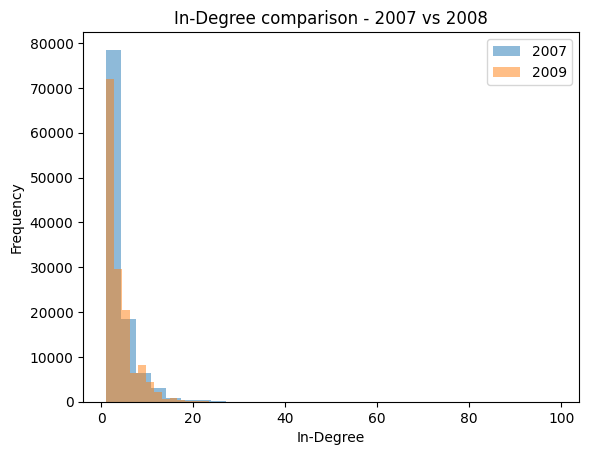

In [174]:
plt.hist([v for k,v in nx.degree(g1)],bins=30, alpha=0.5, label='2007')
plt.hist([v for k,v in nx.degree(g2)],bins=30, alpha=0.5, label='2009')

# Set plot labels and title
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.title('In-Degree comparison - 2007 vs 2008')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Calculate the in-degree for each node
in_degrees = dict(g1.in_degree())

# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.title('In-Degree Distribution')

# Plot the power law curve
x = np.linspace(min(degree_values), max(degree_values), 100)
y = (x ** (-2)) / (sum(degree_values) ** (-2))
plt.plot(x, y, color='red', label='Power Law Curve')

plt.legend()
plt.show()

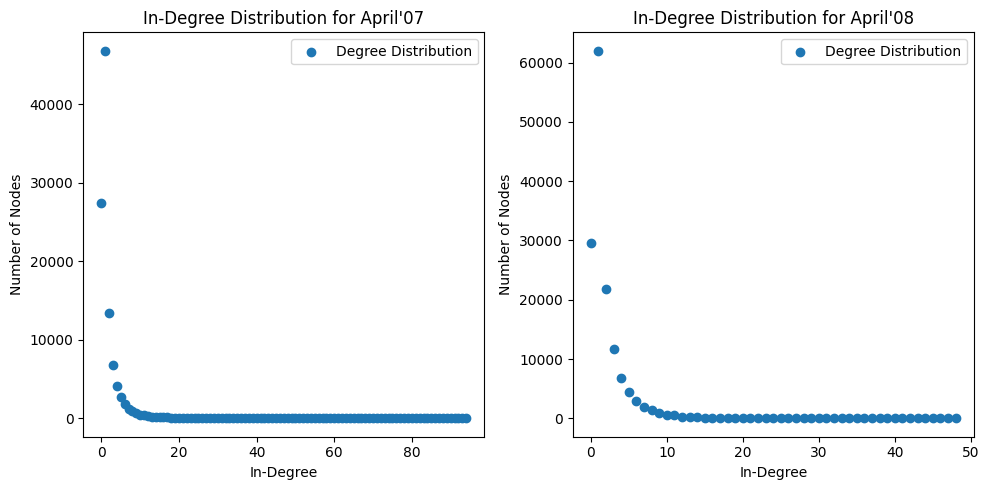

In [282]:
# Calculate the in-degree for each node
in_degrees = dict(g1.in_degree())
# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

in_degrees8 = dict(g2.in_degree())
# Get the in-degree values and corresponding counts
degree_values8 = list(in_degrees8.values())
degree_counts8 = np.bincount(np.array(degree_values8, dtype=int))

# Create a new figure and set the title
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("In-Degree Distribution for April'07")

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts, label='Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("In-Degree Distribution for April'08")

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts8)), degree_counts8, label='Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.legend()

plt.tight_layout()
plt.show()

### <span style="color:teal"> Calculating HITS</span>

In [325]:
h, a = nx.hits(g1)
print(len(h))
print(type(h))

key = []
hub_value = []
for k,v in h.items():
    key.append(k)
    hub_value.append(v)

nodes = []
authority = []
for k,v in a.items():
    nodes.append(k)
    authority.append(v)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


108243
<class 'dict'>


In [326]:
hub_df = pd.DataFrame({'node ID':key,'hub_value':hub_value})
auth_df = pd.DataFrame({'node ID':nodes,'authority_value':authority})

HITS_df = pd.merge(hub_df,auth_df,on='node ID')
HITS_df

,node ID,hub_value,authority_value
0,GEn9QkLAbC8,0.000000e+00,0.000000e+00
1,ooQ2rVCsecA,0.000000e+00,1.536946e-18
2,5k9zhok_iqo,0.000000e+00,1.179867e-18
3,Rtr_GCfFzBI,0.000000e+00,-3.688853e-18
4,jxvetM7uqms,0.000000e+00,4.920717e-19
...,...,...,...
108238,oOjkCOUVeTg,-1.153359e-19,-6.290295e-19
108239,1sGQRy65ItE,0.000000e+00,-2.673073e-18
108240,Di1k5AIdVS0,-1.609618e-20,-1.640303e-18
108241,5gh4Bh_wx8c,-9.549262e-20,-5.908309e-19


In [ ]:
sortedHITS_df = HITS_df.sort_values('hub_value', ascending=False)

### <span style="color:teal">Calculating the simRank Similarity for node</span>

In [328]:
hub_v = HITS_df['hub_value']
hub_v = list(hub_v)
aut_v = HITS_df['authority_value']
aut_v = list(aut_v)

In [329]:
D01 = count_frequency(hub_v)
names_h = list(D01.keys())
values_h = list(D01.values())

D02 = count_frequency(aut_v)
names_a = list(D02.keys())
values_a = list(D02.values())

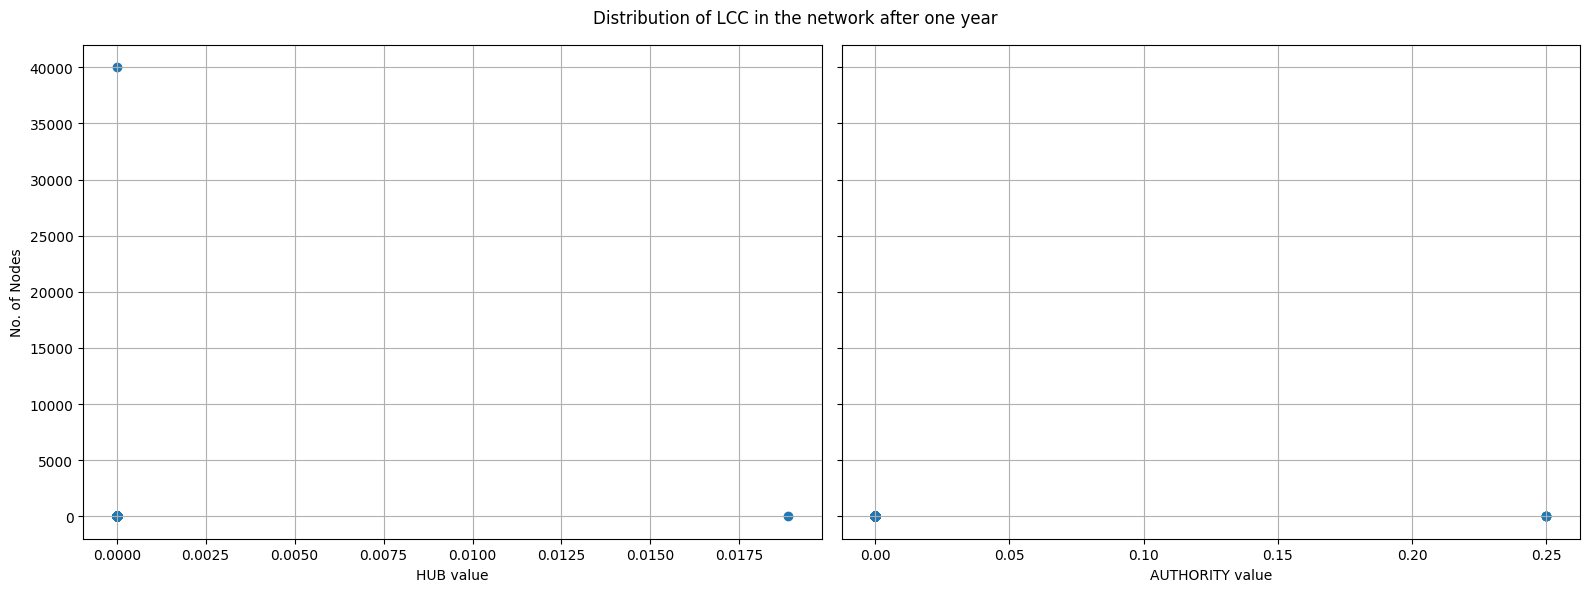

In [331]:
# Plot the in-degree distribution
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axs[0].scatter(names_h,values_h, label='HUB Distribution for 2007')
axs[0].grid(True)
axs[0].set_ylabel('No. of Nodes')
axs[0].set_xlabel('HUB value')
axs[1].scatter(names_a,values_a, label='AUT Distribution for 2007')
axs[1].grid(True)
axs[1].set_xlabel('AUTHORITY value')

fig.suptitle('Distribution of LCC in the network after one year')
plt.tight_layout()
plt.show()

### <span style="color:teal">Calculating the Eccentricity of each strongly connected component, LCC</span>

In [50]:
def ecc_df_maker(graph):
    # Get the strongly connected components
    strong_components = nx.strongly_connected_components(graph)

    # Calculate eccentricity for each strongly connected component
    eccentricities = []
    for component in strong_components:
        subgraph = graph.subgraph(component)
        if nx.is_strongly_connected(subgraph):
            eccentricity = nx.eccentricity(subgraph)
            eccentricities.extend(eccentricity.values())

    # Create a dataframe to store eccentricity values
    df_eccentricity = pd.DataFrame({'Eccentricity': eccentricities})

    # Display the dataframe
    return df_eccentricity

In [51]:
ecc_df = ecc_df_maker(g1)
ecc_df.tail(7)

,Eccentricity
108236,0
108237,0
108238,0
108239,0
108240,0
108241,0
108242,0


In [52]:
# Filter the DataFrame based on a value in a column
filtered_df = ecc_df[ecc_df['Eccentricity'] > 19]

# Display the filtered DataFrame
print(filtered_df)

       Eccentricity
35878            20


### <span style="color:teal">Calculating the Local clustering coefficient of each node - LCC</span>

In [136]:
# Calculate the local clustering coefficient (LCC)
def LCC(G):
    local_clustering = nx.clustering(G, nodes=G.nodes())

    # Store the local clustering coefficient in a dictionary
    clustering_coefficients = {}
    for node, clustering_coefficient in local_clustering.items():
        clustering_coefficients[node] = clustering_coefficient
        
    # Transferring the data from dictionary to dataframe
    K = []
    V = []
    for k,v in clustering_coefficients.items():
        key = k
        value = clustering_coefficients[k]
        K.append(key)
        V.append(value)
    
    df = pd.DataFrame({'node_ID': K, 'LCC': V})

    return df

In [272]:
LCC_df1 = LCC(g1)
LCC_df2 = LCC(g2)
LCC_df1_wc = LCC(giant_subgraph)

In [138]:
# we can add this data to the node attribute csv to get better results in the visualisation
LCC_df1.head(8)
#LCC_df1.describe()

,node_ID,LCC
0,GEn9QkLAbC8,0.000000
1,ooQ2rVCsecA,0.000000
2,5k9zhok_iqo,0.000000
3,Rtr_GCfFzBI,0.000000
4,jxvetM7uqms,0.000000
5,Me82R7DKsMU,0.000000
6,zF6-RBTAs60,0.000000
7,DAKJagJqKtU,0.166667


In [202]:
# Calculate the LCC for each node in the graph
#in_degrees = dict(g1.in_degree())
lcc = LCC_df1['LCC']
lcc = list(lcc)
lcc2 =LCC_df2['LCC']
lcc2 = list(lcc2)

In [273]:
lcc3 = LCC_df2['LCC']
lcc3 = list(lcc3)

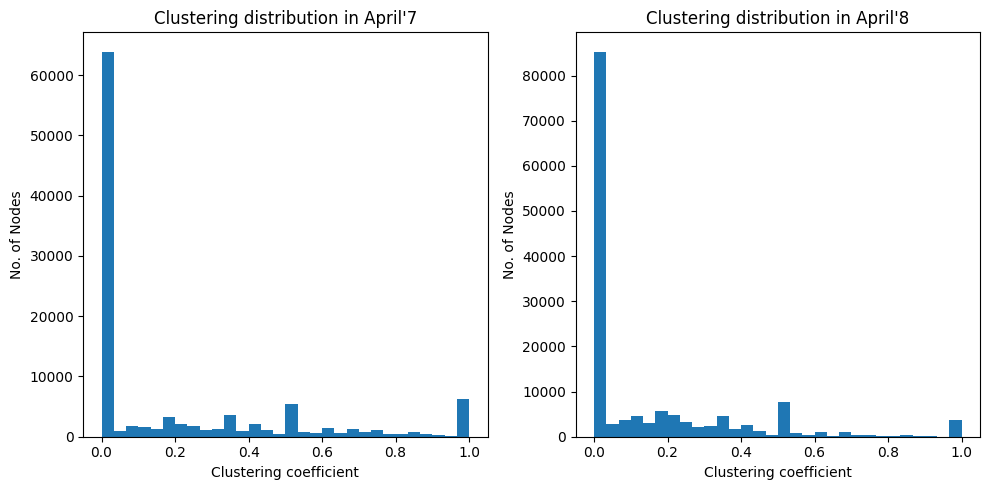

In [218]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(lcc,bins=30)
plt.title("Clustering distribution in April'7")
plt.xlabel('Clustering coefficient')
plt.ylabel('No. of Nodes')

plt.subplot(1, 2, 2)
plt.hist(lcc2,bins=30)
plt.title("Clustering distribution in April'8")
plt.xlabel('Clustering coefficient')
plt.ylabel('No. of Nodes')

plt.tight_layout()
plt.show()

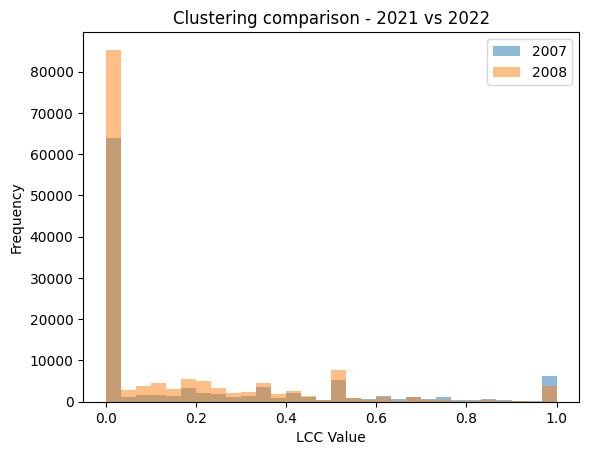

In [204]:
# Plotting the histogram
plt.hist(lcc, bins=30, alpha=0.5, label='2007')
plt.hist(lcc2, bins=30, alpha=0.5, label='2008')

# Set plot labels and title
plt.xlabel('LCC Value')
plt.ylabel('Frequency')
plt.title('Clustering comparison - 2021 vs 2022')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [205]:
def count_frequency(values):
    frequency_dict = {}

    for value in values:
        if value in frequency_dict:
            frequency_dict[value] += 1
        else:
            frequency_dict[value] = 1

    return frequency_dict

In [277]:
lcc.sort()
lcc2.sort()
lcc3.sort()

D1 = count_frequency(lcc)
D2 = count_frequency(lcc2)
D3 = count_frequency(lcc3)

In [306]:
names = list(D1.keys())
values = list(D1.values())

names2 = list(D2.keys())
values2 = list(D2.values())

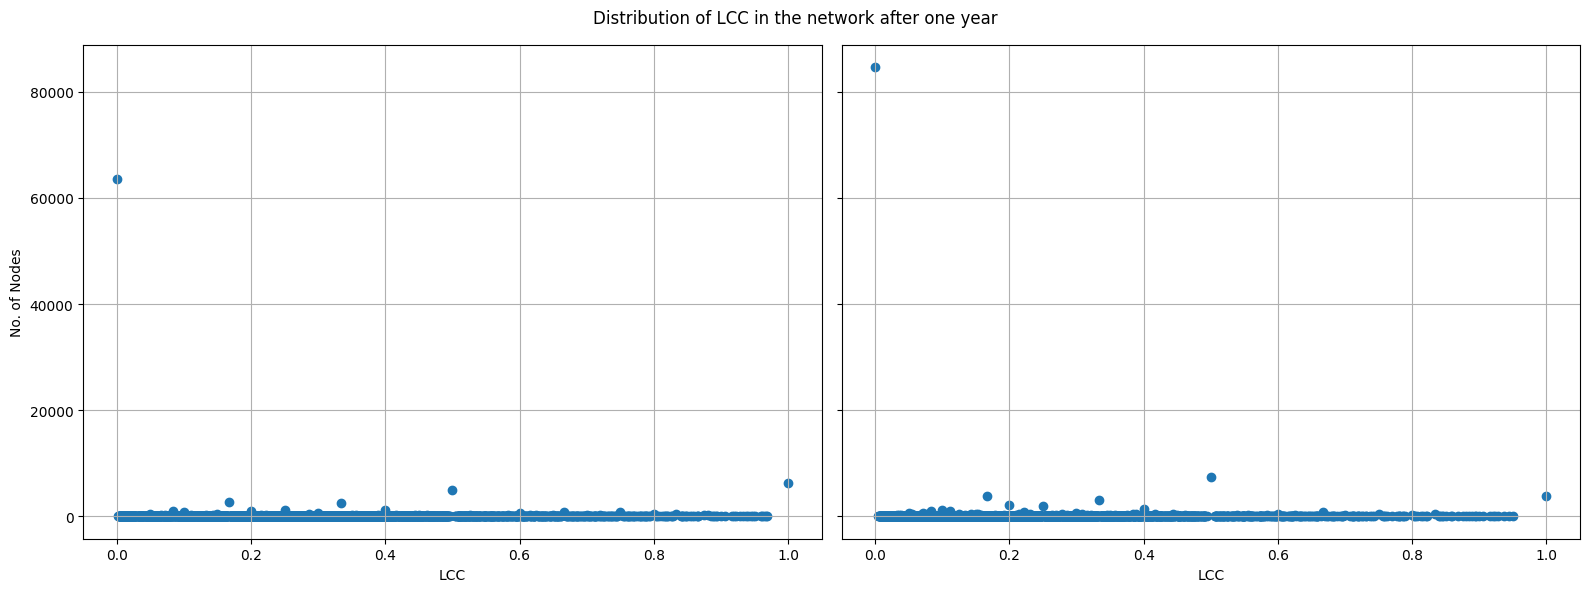

In [324]:
# Plot the in-degree distribution
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axs[0].scatter(names,values, label='LCC Distribution for 2007')
axs[0].grid(True)
axs[0].set_ylabel('No. of Nodes')
axs[0].set_xlabel('LCC')
axs[1].scatter(names2,values2, label='LCC Distribution for 2008')
axs[1].grid(True)
axs[1].set_xlabel('LCC')

fig.suptitle('Distribution of LCC in the network after one year')
plt.tight_layout()
plt.show()

In [278]:
names = list(D3.keys())
values = list(D3.values())
print(len(names))
print(len(values))

2172
2172


Text(0.5, 0.98, 'Categorical Plotting')

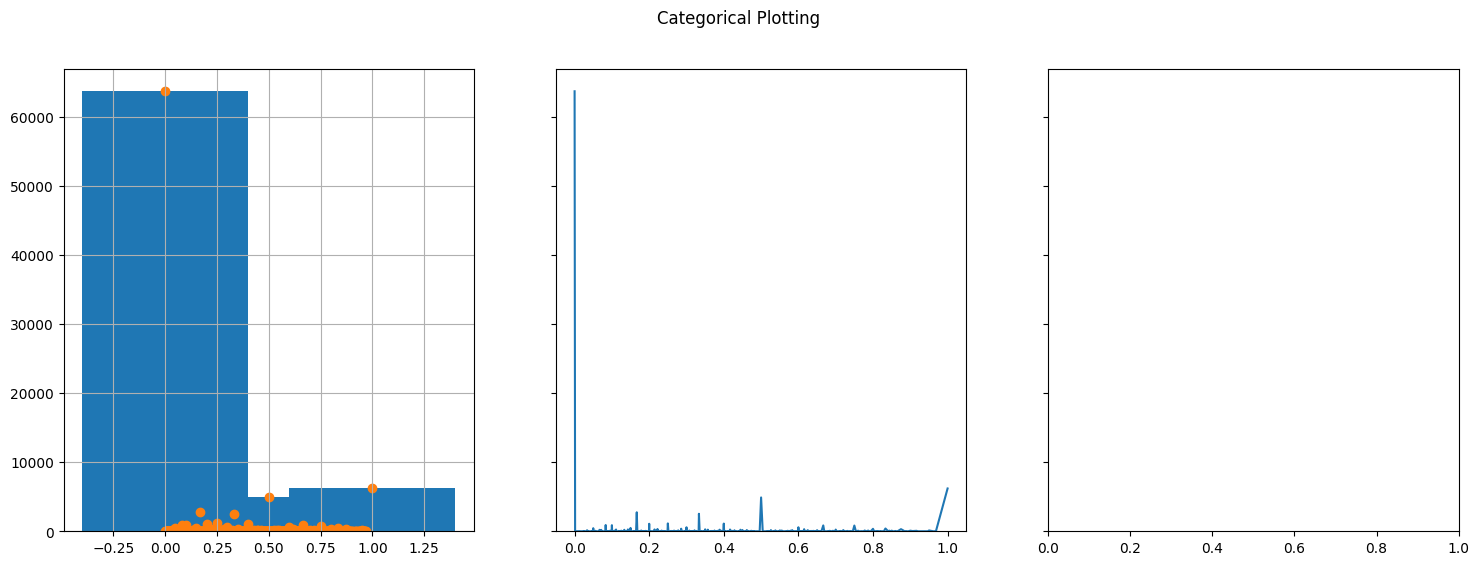

In [312]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].bar(names, values)
axs[0].grid(True)
axs[0].scatter(names, values)
axs[1].plot(names, values)
fig.suptitle('Categorical Plotting')


In [209]:
names = list(D2.keys())
values = list(D2.values())
print(len(names))
print(len(values))

2172
2172


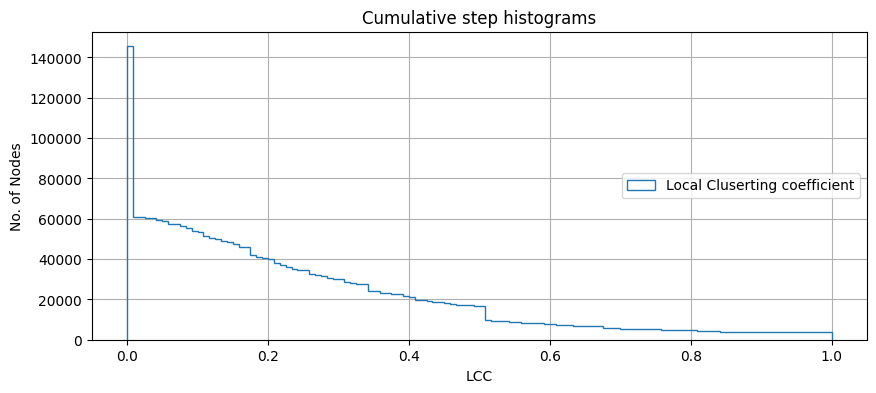

In [280]:
np.random.seed(19680801)

#mu = 200
#sigma = 25
#n_bins = 50
#x = np.random.normal(mu, sigma, size=100)  #this is the data array

fig, ax = plt.subplots(figsize=(10, 4))

# plot the cumulative histogram
'''
n, bins, patches = ax.hist(lcc, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
'''
# Overlay a reversed cumulative histogram.
ax.hist(lcc3, bins=120, density=False, histtype='step', cumulative=-1,
        label='Local Cluserting coefficient')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('LCC')
ax.set_ylabel('No. of Nodes')

plt.show()

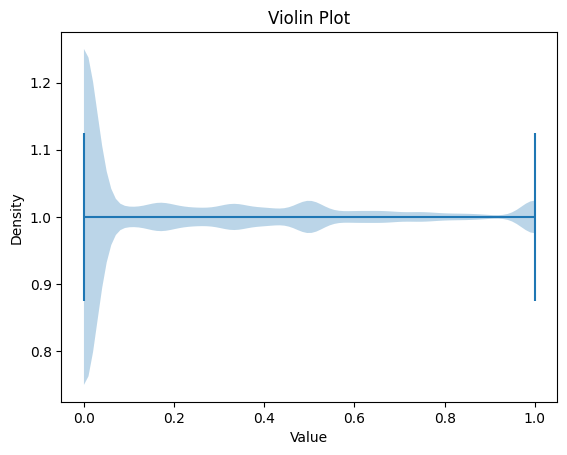

In [239]:
plt.violinplot(lcc, vert=False)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Violin Plot')
plt.show()


### <span style="color:teal">Checking Isomorphism of two graphs</span>

In [60]:
test = nx.is_isomorphic(g1,g2)
print("Isomporgic graphs? - ",test)

test = nx.faster_could_be_isomorphic(g1,g2)
print("Isomporgic graphs? - ",test)

Isomporgic graphs? -  False
Isomporgic graphs? -  False


### <span style="color:teal">Checking cliques in the graphs</span>

In [61]:
def clique_calc(graph):
    # Convert the directed graph to an undirected graph
    undirected_graph = graph.to_undirected()

    # Find all cliques in the undirected graph
    cliques = list(nx.find_cliques(undirected_graph))

    # Get the number of cliques
    num_cliques = len(cliques)

    print("Number of Cliques:", num_cliques)

In [62]:
clique_calc(g1) # output - 93,297

Number of Cliques: 93297


In [63]:
clique_calc(g2) # output - 1,42,788

Number of Cliques: 142788


### <span style="color:teal">Checking common nodes in both graphs</span>

In [89]:
def find_common_nodes(graph1, graph2):
    """
    Find the set of common nodes between two graphs.

    Parameters:
        graph1 (networkx.Graph): The first graph.
        graph2 (networkx.Graph): The second graph.

    Returns:
        set: The set of common nodes between the two graphs.
    """
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1.intersection(nodes2)
    return common_nodes

In [90]:
c_set = find_common_nodes(g1,g2)
len(c_set)

1205

In [91]:
for i in range(7):
    print(c_set.pop())

QtEI-UHxz0Q
rGk9E4oKYYI
7WOO75Egboc
tbRXSeTckfQ
2SSh-rEiXyw
Bk7CxHCasts
RDZWerC4kgA


### <span style="color:teal">Checking EGO network of the graphs</span>

In [64]:
def get_ego_network(graph, node, depth):
    """
    Get the ego network of a node from a directed graph with a specified depth.

    Parameters:
        graph (networkx.DiGraph): The directed graph.
        node: The target node to compute the ego network.
        depth (int): The depth or radius of the ego network.

    Returns:
        networkx.DiGraph: The ego network as a directed graph.
    """
    ego_network = nx.ego_graph(graph, node, radius=depth, center=True, undirected=True)  # undirected parameters allow us control wether to control the incoming and outgoing nodes or not
    return ego_network

Now we create the ego network of a node which is present in both the networks and compare its evolution

In [113]:
ego_depthC1_1 = get_ego_network(g1,'rGk9E4oKYYI',1)
ego_depthC2_1 = get_ego_network(g2,'rGk9E4oKYYI',1)

ego_depthC1_2 = get_ego_network(g1,'rGk9E4oKYYI',2)
ego_depthC2_2 = get_ego_network(g2,'rGk9E4oKYYI',2)

ego_depthC1_3 = get_ego_network(g1,'rGk9E4oKYYI',3)
ego_depthC2_3 = get_ego_network(g2,'rGk9E4oKYYI',3)

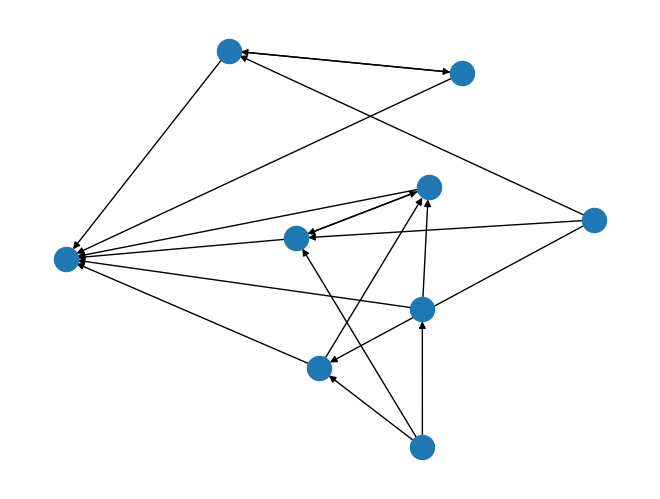

In [114]:
nx.draw_spring(ego_depthC1_3)

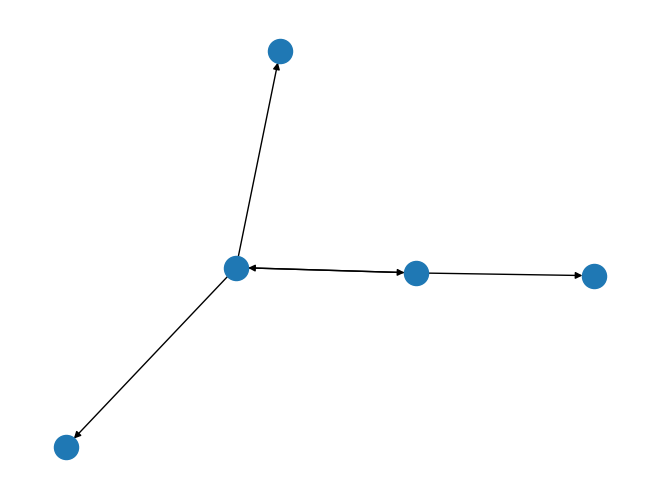

In [115]:
nx.draw_spring(ego_depthC2_3)

In [116]:
#df for ego network at depth1 for both years
egoNet_depth1_7 = df_for_egoNet(ego_depthC1_1)
egoNet_depth1_8 = df_for_egoNet(ego_depthC2_1)

#df for ego network at depth2 for both years
egoNet_depth2_7 = df_for_egoNet(ego_depthC1_2)
egoNet_depth2_8 = df_for_egoNet(ego_depthC2_2)

#df for ego network at depth2 for both years
egoNet_depth3_7 = df_for_egoNet(ego_depthC1_3)
egoNet_depth3_8 = df_for_egoNet(ego_depthC2_3)

In [128]:
egoNet_depth1_7

,Node,uploader,age,category,length,views,rate,ratings,comments
0,RI7w3nF2eis,live8706,752.0,Entertainment,242.0,3154.0,3.75,8.0,3.0
1,rGk9E4oKYYI,beverlyhills90210fan,483.0,Entertainment,24.0,10453.0,4.83,12.0,10.0
2,u4zvq0nBBWE,beverlyhills90210fan,483.0,Entertainment,25.0,7846.0,4.80,10.0,4.0


In [135]:
egoNet_depth1_8.describe()

,age,length,views,rate,ratings,comments
count,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,642.000000,50.500000,17811.500000,4.78500,23.500000,34.500000
std,224.859956,37.476659,10406.490499,0.06364,16.263456,34.648232
min,483.000000,24.000000,10453.000000,4.74000,12.000000,10.000000
25%,562.500000,37.250000,14132.250000,4.76250,17.750000,22.250000
50%,642.000000,50.500000,17811.500000,4.78500,23.500000,34.500000
75%,721.500000,63.750000,21490.750000,4.80750,29.250000,46.750000
max,801.000000,77.000000,25170.000000,4.83000,35.000000,59.000000


In [120]:
egoNet_depth1_8.describe()

,age,length,views,rate,ratings,comments
count,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,642.000000,50.500000,17811.500000,4.78500,23.500000,34.500000
std,224.859956,37.476659,10406.490499,0.06364,16.263456,34.648232
min,483.000000,24.000000,10453.000000,4.74000,12.000000,10.000000
25%,562.500000,37.250000,14132.250000,4.76250,17.750000,22.250000
50%,642.000000,50.500000,17811.500000,4.78500,23.500000,34.500000
75%,721.500000,63.750000,21490.750000,4.80750,29.250000,46.750000
max,801.000000,77.000000,25170.000000,4.83000,35.000000,59.000000


Now we take a random node from a popular category and see its Ego network and if it follows the same tendencies as observed before.

In [88]:
ego_depth1 = get_ego_network(g1,'a3CeuLRB9FQ',1)  #dA5bf5jG2co  #sbbKACWzvG0
ego_depth2 = get_ego_network(g1,'a3CeuLRB9FQ',2)
ego_depth3 = get_ego_network(g1,'a3CeuLRB9FQ',3)

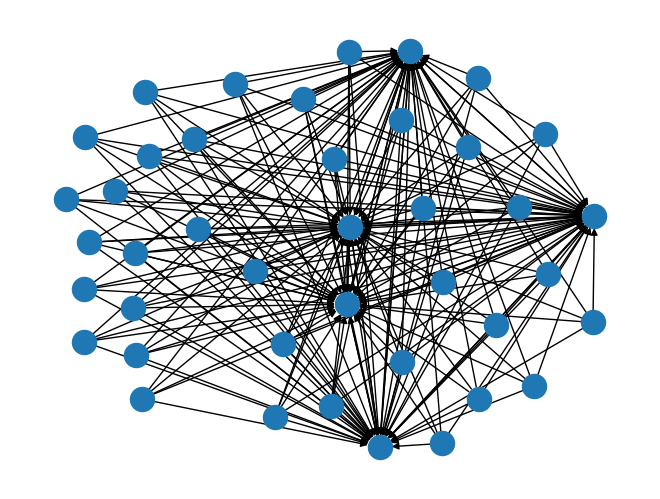

In [66]:
nx.draw_spring(ego_depth1)

In [67]:
def df_for_egoNet(subgraph):
    # Create a dictionary to store node attributes
    node_attributes = {}

    # Iterate over the nodes and their attributes in the ego network
    for node, attrs in subgraph.nodes(data=True):
        node_attributes[node] = attrs

    # Create a DataFrame from the node attributes dictionary
    node_data = pd.DataFrame.from_dict(node_attributes, orient='index')

    # Reset the index and rename columns
    node_data.reset_index(inplace=True)
    node_data.columns = ['Node'] + list(node_data.columns[1:])
    
    return node_data

In [72]:
# Print the node information DataFrame
egoNet_depth1 = df_for_egoNet(ego_depth1)
egoNet_depth2 = df_for_egoNet(ego_depth2)
egoNet_depth3 = df_for_egoNet(ego_depth3)
egoNet_depth1.tail()

,Node,uploader,age,category,length,views,rate,ratings,comments
36,xlyhewSQM8o,sonybmg,775.0,Music,341.0,1756.0,4.40,5.0,3.0
37,59ip81GrkFs,sonybmg,731.0,Music,222.0,39160.0,4.87,161.0,84.0
38,2Iec0tNOzCc,sonybmg,775.0,Music,280.0,919.0,4.78,9.0,2.0
39,kkZbi-7rMms,sonybmg,775.0,Music,325.0,2089.0,5.00,14.0,4.0
40,eqtIPZo52A4,sonybmg,775.0,Music,249.0,337.0,5.00,3.0,7.0


In [71]:
egoNet_depth1.describe()

,age,length,views,rate,ratings,comments
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,755.756098,239.317073,3790.390244,4.695366,15.658537,6.341463
std,19.933365,33.823394,10662.555374,0.828076,33.249519,16.029051
min,731.000000,193.000000,116.000000,0.000000,0.000000,0.000000
25%,737.000000,210.000000,413.000000,4.780000,4.000000,1.000000
50%,773.000000,237.000000,943.000000,5.000000,6.000000,2.000000
75%,775.000000,258.000000,2089.000000,5.000000,11.000000,4.000000
max,775.000000,341.000000,58216.000000,5.000000,161.000000,84.000000


In [85]:
egoNet_depth2.describe()

,age,length,views,rate,ratings,comments
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,709.000000,233.680000,5141.426667,4.338133,16.333333,8.053333
std,78.294834,68.805672,12893.890424,1.299730,32.543664,16.492335
min,473.000000,26.000000,57.000000,0.000000,0.000000,0.000000
25%,649.000000,207.500000,407.000000,4.435000,2.500000,1.000000
50%,737.000000,238.000000,1229.000000,4.870000,6.000000,2.000000
75%,775.000000,261.500000,2836.500000,5.000000,12.500000,5.000000
max,775.000000,493.000000,81401.000000,5.000000,166.000000,84.000000


In [86]:
egoNet_depth3.describe()

,age,length,views,rate,ratings,comments
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,682.157407,224.083333,7120.083333,4.275000,19.250000,7.898148
std,94.137915,84.672334,19943.281517,1.373996,43.369554,16.363248
min,447.000000,15.000000,42.000000,0.000000,0.000000,0.000000
25%,615.500000,203.750000,436.000000,4.422500,2.000000,1.000000
50%,734.000000,234.000000,1224.000000,4.830000,6.000000,2.000000
75%,755.250000,261.250000,3136.000000,5.000000,12.250000,5.250000
max,775.000000,598.000000,142159.000000,5.000000,281.000000,84.000000


>From the output above, in the standard deviation row for the `age` attribute, we see the lowest deviation, we are choosing to ignore the STD value of rate cause it has a very small range(1-5). 

In [73]:
df_sim = simrank_similarity(ego_depth1)

In [77]:
df_sim

,-s8_LlQ6BIA,0NjfRqvzhmI,2Iec0tNOzCc,2lxTI4J6tNs,59ip81GrkFs,6OF2lMv5yRw,7DaJ4ZBvQvg,7ItYVn2jcGU,9fiFn0FoVs4,D8n_c0m-tLI,...,llUkiR0cceY,n0BqB48r-Fc,p4VAGo7QfC8,qTkkYCWo2U0,w2AtlHFl5AY,w7TErn3uJAQ,wKU59TlqVxQ,wUfj_X22uak,xlyhewSQM8o,zrkaVueViTE
-s8_LlQ6BIA,0.000000,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
0NjfRqvzhmI,0.000006,0.000000,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
2Iec0tNOzCc,0.000006,0.000006,0.000000,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
2lxTI4J6tNs,0.000006,0.000006,0.000006,0.000000,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
59ip81GrkFs,0.000006,0.000006,0.000006,0.000006,0.000000,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
6OF2lMv5yRw,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
7DaJ4ZBvQvg,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
7ItYVn2jcGU,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.000006,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
9fiFn0FoVs4,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,0.000006,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005
D8n_c0m-tLI,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000000,...,0.000006,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005


### <span style="color:teal">Analysing the clustering in the weakly connected components</span>

In [332]:
def transitivity_df_maker(G):
  values = []
  sizes = []
  clusts = []
  effi_values = []
  components = nx.weakly_connected_components(G)

  for component in tqdm(components):
      component_graph = G.subgraph(component)
      # calculating its trasitivity per component
      tra_value= nx.transitivity(component_graph)
      values.append(tra_value)

      # calculating its size
      component_size = len(component)
      sizes.append(component_size)

      # calculating its average clustering
      clust = nx.average_clustering(component_graph)
      clusts.append(clust)

      # calculating the local efficieny of the components
      component_graphU = component_graph.to_undirected()
      effi = nx.local_efficiency(component_graphU)
      effi_values.append(effi)
  transitivity_df = pd.DataFrame({'Component Size':sizes,'transitivity':values,'average clustering':clusts,'local efficiency':effi_values})
  return transitivity_df

In [333]:
tra_DF = transitivity_df_maker(g1)
tra_DF = tra_DF.sort_values(by='Component Size', ascending=False)

13786it [00:13, 1054.31it/s]


In [334]:
tra_DF.head(10)

,Component Size,transitivity,average clustering,local efficiency
0,40389,0.414432,0.208039,0.324296
1342,308,0.428770,0.228768,0.377233
1355,282,0.456904,0.306761,0.471494
469,251,0.389845,0.140052,0.217831
58,236,0.525940,0.312153,0.458773
2315,231,0.478755,0.267224,0.422577
65,194,0.369610,0.177923,0.269948
477,190,0.463030,0.331911,0.530467
377,173,0.452984,0.201683,0.302353
3849,141,0.617260,0.339478,0.492035


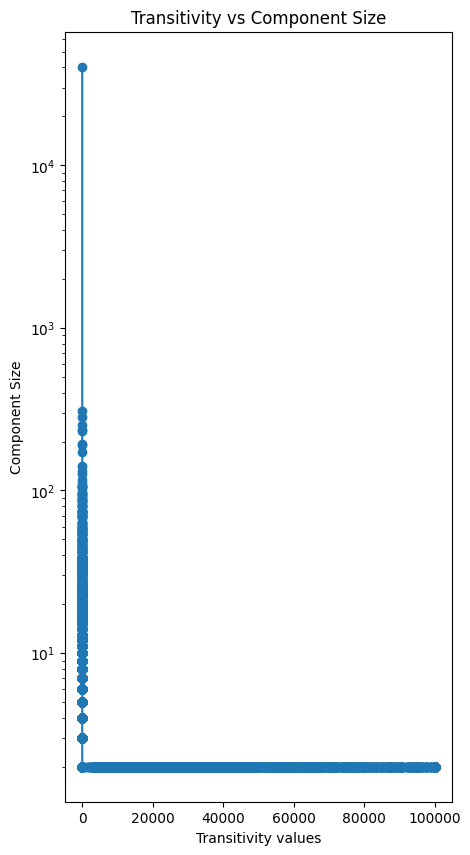

In [365]:
#scalling the values for better visualisation
listed = list(tra_DF['transitivity'])
listed.sort()
i=0
for i in range(len(listed)):
    listed[i] = listed[i]*100000

# Plotting the chart
plt.figure(figsize=(5, 10))
plt.plot(listed,list(tra_DF['Component Size']), 'o-')

# Set plot labels and title
plt.xlabel('Transitivity values')
plt.ylabel('Component Size')
plt.title('Transitivity vs Component Size')

# Adjust axis scales
plt.yscale('log')  # Set x-axis scale to logarithmic
# Show the plot
plt.show()

In [83]:
tra_DF2 = transitivity_df_maker(g2)
tra_DF2 = tra_DF2.sort_values(by='Component Size', ascending=False)

10175it [00:16, 627.47it/s] 


In [350]:
tra_DF2.head(10)

,Component Size,transitivity,average clustering,local efficiency
0,86773,0.251185,0.157354,0.250712
115,456,0.294812,0.252464,0.392434
1399,374,0.402542,0.305840,0.489655
46,225,0.242297,0.189231,0.308050
524,211,0.244645,0.186646,0.330547
225,191,0.105357,0.085058,0.140491
925,185,0.197333,0.144337,0.213552
164,180,0.294747,0.185092,0.311414
603,178,0.170431,0.154585,0.213418
961,174,0.206553,0.151123,0.239550


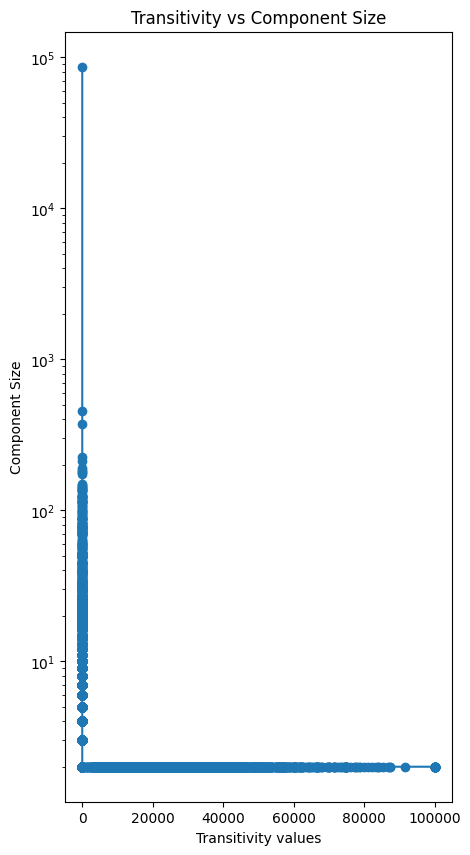

In [362]:
#scalling the values for better visualisation
listed = list(tra_DF2['transitivity'])
listed.sort()
i=0
for i in range(len(listed)):
    listed[i] = listed[i]*100000

# Plotting the chart
plt.figure(figsize=(5, 10))
plt.plot(listed,list(tra_DF2['Component Size']), 'o-')

# Set plot labels and title
plt.xlabel('Transitivity values')
plt.ylabel('Component Size')
plt.title('Transitivity vs Component Size')

# Adjust axis scales
plt.yscale('log')  # Set x-axis scale to logarithmic

# Show the plot
plt.show()

### <span style="color:teal">Exporting the graphs</span>

In [ ]:
export(g1,'g1.gexf.gz')

In [ ]:
export(g2,'g2.gexf.gz')

In [78]:
strong_components1 = list(nx.strongly_connected_components(g1))
strong_components1.sort(key=len,reverse=True)
strong_components2 = list(nx.strongly_connected_components(g2))
strong_components2.sort(key=len,reverse=True)

In [79]:
# making a strong component graph for simrank testing
sg = strong_components1[0]
sg_1 = g1.subgraph(sg)
print("Density:", nx.density(sg_1))
diameter_directed(sg_1)  # gephi shows the network diameter as 64 but networkX shows 43
print("Reciprocity:", nx.reciprocity(sg_1))
print("Average in-degree:", sum(dict(sg_1.in_degree()).values()) / sg_1.number_of_nodes())
print("Average out-degree:", sum(dict(sg_1.out_degree()).values()) / sg_1.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(sg_1))
print("Transitivity:", nx.transitivity(sg_1))
print("Number of strongly connected components:", nx.number_strongly_connected_components(sg_1))  #output - 2,79,984
print("Number of weakly connected components:", nx.number_weakly_connected_components(sg_1)) # output - 23,818
print(nx.is_directed_acyclic_graph(sg_1))

Density: 0.016002681077458003
Network Diameter: 18
Reciprocity: 0.16230366492146597
Average in-degree: 3.4885844748858448
Average out-degree: 3.4885844748858448
Assortativity coefficient: 0.13055472152971276
Transitivity: 0.2365038560411311
Number of strongly connected components: 1
Number of weakly connected components: 1
False


In [214]:
def simrank_similarity_DF(graph, C=0.8, max_iterations=10):
    # Get a sorted list of nodes in the graph
    nodes = sorted(graph.nodes())

    # Initialize similarity matrix with zeros
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))

    # Set initial similarity values
    np.fill_diagonal(similarity_matrix, 1.0)

    # SimRank algorithm
    for iteration in range(max_iterations):
        new_similarity_matrix = np.zeros((num_nodes, num_nodes))

        for u_idx, u in enumerate(nodes):
            for v_idx, v in enumerate(nodes):
                if u != v:
                    u_neighbors = set(graph.neighbors(u))
                    v_neighbors = set(graph.neighbors(v))
                    common_neighbors = u_neighbors.intersection(v_neighbors)

                    if len(common_neighbors) > 0:
                        s_uv = sum(similarity_matrix[nodes.index(u_nb)][nodes.index(v_nb)] for u_nb in common_neighbors for v_nb in common_neighbors)
                        new_similarity_matrix[u_idx][v_idx] = C * (s_uv / (len(u_neighbors) * len(v_neighbors)))

        # Update similarity matrix
        similarity_matrix = new_similarity_matrix

    # Create a DataFrame with similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=nodes, columns=nodes)
    return similarity_df

In [217]:
simrank_result = simrank_similarity(ego_depth2)
simrank_result

,Ht_8uF4hMNY,LQF-iPwfeic,MBn6mz61DM8,N-caep9PcQA,WLNlhK9vbN4,cyqi5Ooy0nw,sbbKACWzvG0,wq_-OW_Hln8
Ht_8uF4hMNY,0.000000e+00,0.0,1.500000e-10,0.0,1.500000e-10,1.500000e-10,0.0,0.0
LQF-iPwfeic,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0
MBn6mz61DM8,1.500000e-10,0.0,0.000000e+00,0.0,1.500000e-10,1.500000e-10,0.0,0.0
N-caep9PcQA,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0
WLNlhK9vbN4,1.500000e-10,0.0,1.500000e-10,0.0,0.000000e+00,1.500000e-10,0.0,0.0
cyqi5Ooy0nw,1.500000e-10,0.0,1.500000e-10,0.0,1.500000e-10,0.000000e+00,0.0,0.0
sbbKACWzvG0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0
wq_-OW_Hln8,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0


#### counting Number of strongly connected components in each graph

In [224]:
s_components = nx.strongly_connected_components(g1)
s_components2 = nx.strongly_connected_components(g2)

s = 0
for item in s_components:
    if len(item)> s:
        s = len(item)

s

219

In [225]:
s = 0
for item in s_components2:
    if len(item)> s:
        s = len(item)
s

1635

In [ ]:
# iterating over the df to see if any value is above zero
for idx,row in df_matrix.iterrows():
    for label, content in row.items():
        if content > 0:
            print(f'index: {idx}')
            print(f'label: {label}')
            print(f'content: {content}', sep='\n')

In [ ]:
result_df = simrank_similarity_DF(sg_1)
result_df.tail(5)

In [ ]:
# iterating over the df to see if any value is above zero
for idx,row in result_df.iterrows():
    for label, content in row.items():
        if content > 0:
            print(f'index: {idx}')
            print(f'label: {label}')
            print(f'content: {content}', sep='\n')

In [ ]:
# checking component isomorphism between the strongly connected components of the two network graphs
for i in range(89797):
    component_i = strong_components1[i]
    for j in range(100000): 
        component_j = strong_components2[j]
        #print(len(component_i),len(component_j))
        #is_isomorphic = nx.is_isomorphic(g1.subgraph(component_i), g2.subgraph(component_j))
        if len(component_i) == len(component_j) and len(component_i) > 7:
            #print("same length found")
            #undirected_graph = directed_graph.to_undirected()
            is_isomorphic = nx.is_isomorphic(g1.subgraph(component_i).to_undirected(), g2.subgraph(component_j).to_undirected())
            couldBe_isomorphic = nx.faster_could_be_isomorphic(g1.subgraph(component_i).to_undirected(), g2.subgraph(component_j).to_undirected())
            if is_isomorphic:
                print(len(component_i),len(component_j))
                print(is_isomorphic)

From the above code we can see that there are some strongly connected components which `could be` isomorphic. These components all have 8 nodes and that seems to be the limit till which the youtube algorithm keeps the videos is a ismoprphic state after that each component develops their own ido-syncracies we assume. 

If we converted the directed subgraphs into undirected graphs, then the number of isomorhpic components increase as well as the number of nodes in these components go up to 10 but that seems to be the limit there.

We also can find some case of `sure` isomorphism with upto 8 nodes in the the component.

In [ ]:
def subgraph_category(graph,attribute,values):
   # Filter the subgraph based on a specific attribute value
    attribute_key = attribute
    attribute_values = values
    subgraph_nodes = [n for n, data in graph.nodes(data=True) if attribute_key in data and data[attribute_key] in attribute_values]
    subgraph = graph.subgraph(subgraph_nodes)


    # Print the nodes in the subgraph
    #print("Nodes in the subgraph:")
    #print(subgraph.nodes())
    
    # Print the length (number of nodes) in the subgraph
    subgraph_length = len(subgraph)
    print("Length of nodes in the subgraph:", subgraph_length)
    return subgraph

In [ ]:
attri = 'category'
value1 = ['Entertainment','Music']
g1_enterainment = subgraph_category(g1,attri,value1)

subgraph_length = len(g1_enterainment)
print("Length of nodes in the subgraph:", subgraph_length)

In [ ]:
export(g1_enterainment,'g1_entertainment.gexf.gz')